In [ ]:
!pip install inferactively-pymdp
import pymdp
from pymdp import utils
from pymdp.agent import Agent
import numpy as np
import scipy
import os.path
import statistics as st
import seaborn as sb
from numpy import nan
from matplotlib import pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 KB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 KB 616.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 KB 

In [ ]:
class SearchEnv(object):
    def __init__(self, D, n, B):

        self.start = SearchEnv.one_hot(n, np.argmax(D))
        self.state = self.start
        self.n     = n
        self.B_obj = B[0]
        self.B_act = B[1]
        
    def reset(self):
        self.state = self.start
        
    def step(self, action):
        B_choice = self.B_act[:, :, action]
        self.state = B_choice@self.state
        
    @staticmethod
    def one_hot(n, idx):
        vec = np.zeros(n)
        vec[idx] = 1.0
        return vec
        

init_switch = 8

class Sim(object):
    def get_obs(self, x, time):
      context = 0 # No observation

      if time >= init_switch:
        context = 3 ## Observation at hand position 3/5

      if context == 0:
        return [1]
    
      return [0 if x[context] == 1 or x[8-context] == 1 else 1]
              

def run_active_inference_loop(my_agent, my_env, sim, T):
    ## Initialize the first observation (i.e., nothing sensed)
    obs = [1]
    saveobs, saveq_pi, saveaction, savecont = [], [], [], []
    
    for t in range(T):

        ## Do active inference per time step
        qs = my_agent.infer_states(obs)
        q_pi, efe = my_agent.infer_policies()
        chosen_action_id = my_agent.sample_action()

        ## Save data
        idx = np.argmax(my_env.state)
        saveobs.append(obs)
        saveq_pi.append(q_pi)
        saveaction.append(idx)
        savecont.append(qs[0])

        ## Generate next actions and collect new observations
        my_env.step(int(chosen_action_id[1]))
        obs = sim.get_obs(my_env.state, t + 1)
    return saveobs, saveq_pi, saveaction, savecont     

In [ ]:
num_obs = [2] # Touched/Untouched
num_states = [4, 8] # [object appearance; hand position]
num_factors = len(num_states)
num_controls = [1, 2] # The agent controls the hand movement only, not the object appearance
num_modalities = 1



## Baseline likelihood matrix before precision modulation
A = utils.obj_array( num_modalities )
A[0] = np.ndarray((2, 4, 8))
A[0].fill(.5)
for i in range(1,4):
  A[0][:,i,i] = [1, 0]
  A[0][:,i,8-i] = [1, 0]

## Baseline transition matrix before precision modulation (only B[0] is changed via the precision parameter)

B = utils.obj_array(num_factors)
B[0] = np.ndarray((4, 4, 1))
B[0][:,:,0]  = np.eye(4)

B[1] = np.ndarray((8, 8, 2))
B[1][:,:,0] = np.roll(np.eye(8),-1)
B[1][0,7,0] = 1
B[1][7,7,0] = 0
B[1][:,:,1] = np.zeros((8,8))
B[1][1:3,:2,1] = np.eye(2)

for i in range(6):
  B[1][7-i,2+i,1] = 1

## Baseline initial vector before precision modulation

D = utils.obj_array(num_factors)
D_context = np.array([1, 0, 0, 0])

D[0] = D_context
D_handposition = np.zeros(8)

hand = np.random.randint(0, len(D_handposition))
D_handposition[hand] = 1.0
D[1] = D_handposition


## Baseline habits before precision modulation

E = utils.obj_array(2)
E = np.array([0.75, 0.25]) # Higher probabilities for selecting the high amplitude movement independently on input (i.e., Habits) 

In [ ]:
##################A MULTIPLE PRECISION COMBINATIONS EXPERIMENT##################


## Initialize precision values
ZETA  = np.round(np.linspace(0.01, 0.3, 13), 2)
OMEGA = [0.8] 
RHO   = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.8, 1, 2, 5, 8, 10, 100]
T     = 40
N     = 8 # Number of experiments per one agent
env = SearchEnv(D[1], 8, B)
sim = Sim()
## Initialize matrices for saving data

pol_post = np.zeros((len(ZETA),len(OMEGA),len(RHO),T,len(num_controls),N)) # posterior for policy selection
con_post = np.zeros((len(ZETA),len(OMEGA),len(RHO),T,4,N)) # Expecting posterior probability for inferred object position
actions  = np.zeros((len(ZETA),len(OMEGA),len(RHO),T,N)) # A single value is expected to be returned
obser    = np.zeros((len(ZETA),len(OMEGA),len(RHO),T,N))

# make copies that are used such that the crucial values dont change each iteration
A_use = utils.obj_array(num_modalities)
A_use[0] = np.copy(A[0])
B_use = utils.obj_array(num_factors)
B_use[0] = np.copy(B[0])
B_use[1] = np.copy(B[1])

## Combine all precisions together
for n in range(N):
  for ze, zeta in enumerate(ZETA):
    for om, omega in enumerate(OMEGA):
      for rh, rho in enumerate(RHO):
      
        ## Set up matrices with every precision iteration

        for i in range(1,4):
          A_use[0][:,i,:] = scipy.special.softmax(zeta*np.log(A[0][:,i,:]+np.exp(-8)), axis=0)

        B_use[0][:,:,0] = scipy.special.softmax(omega*np.log(np.eye(4)+np.exp(-8)),axis=0)
        E_use = scipy.special.softmax(rho*np.log(E+np.exp(-8)),axis=0)

        # The D vector is included to provide a random starting hand position
        D_handposition = np.zeros(8)
        # hand = np.random.randint(0, len(D_handposition))
        D_handposition[hand] = 1.0
        D[1] = D_handposition


        ## Assign to the agent and run the loop
        env = SearchEnv(D[1], 8, B_use)
        my_agent = Agent( A = A_use, B = B_use, C = None, D = D, E = E_use, use_utility = True, use_states_info_gain = True)
        saveobs, saveq_pi, saveaction, savecont = run_active_inference_loop(my_agent, env, sim, T)

        ## Collect data
        pol_post[ze,om,rh,:,:,n]   = saveq_pi
        con_post[ze,om,rh,:,:,n]   = savecont
        actions[ze,om,rh,:,n]      = saveaction

## Save data but make sure that they don't repeat
np.save('Contextposterior',con_post)
np.save('Policyposterior',pol_post)
np.save('Handposition',actions)

In [ ]:
pol_post = np.load('Policyposterior.npy')
con_post = np.load('Contextposterior.npy')
actions  = np.load('Handposition.npy')

[Text(33.0, 0.5, 'Zeta'), Text(0.5, 15.0, 'Rho')]

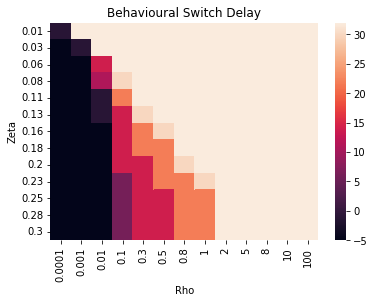

In [ ]:
# i) time delay of a switch policy
pol_switch = np.argmax(pol_post, axis=4)
pol_switch_time = np.zeros((len(ZETA), len(OMEGA), len(RHO), N))
for ze in range(len(ZETA)):
  for om in range(len(OMEGA)):
    for rh in range(len(RHO)):
      for n in range(N):
        # search for times where the policy 1 > policy 0
        nonzeros = np.nonzero(pol_switch[ze, om, rh, :, n])[0]
        pol_switch_time[ze, om, rh, n] = T if not nonzeros.size else nonzeros[0]

pol_switch_time -= init_switch # subtract the timepoint of stimulation start
mean_pol_switch_time = pol_switch_time.mean(axis=3)
std_pol_switch_time = pol_switch_time.std(axis=3)
fig = sb.heatmap(mean_pol_switch_time.squeeze(), xticklabels=RHO, yticklabels=ZETA)
fig.set(title='Behavioural Switch Delay')
fig.set(xlabel='Rho', ylabel='Zeta')

[Text(33.0, 0.5, 'Zeta'), Text(0.5, 15.0, 'Rho')]

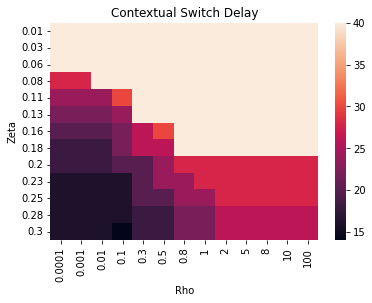

In [ ]:
# ii) Contextual switch delay
used_context = np.argmax(con_post, axis=4)
switch_time = np.zeros((len(ZETA), len(OMEGA), len(RHO), N))
for ze in range(len(ZETA)):
  for om in range(len(OMEGA)):
    for rh in range(len(RHO)):
      for n in range(N):
        v_forw = used_context[ze, om, rh, :-1, n]
        v_back = used_context[ze, om, rh, 1:, n]
        context_switches = np.where(v_forw != v_back)[0] # search for number switches in the rows
        if len(context_switches) >= 1:
          switch_time[ze, om, rh, n] = context_switches[0] - init_switch
        else:
          switch_time[ze, om, rh, n] = T

mean_switch_times = switch_time.mean(axis=-1)
fig = sb.heatmap(mean_switch_times.squeeze(), xticklabels=RHO, yticklabels=ZETA)
fig.set(title='Contextual Switch Delay')
fig.set(xlabel='Rho', ylabel='Zeta')

[Text(33.0, 0.5, 'Zeta'), Text(0.5, 15.0, 'Rho')]

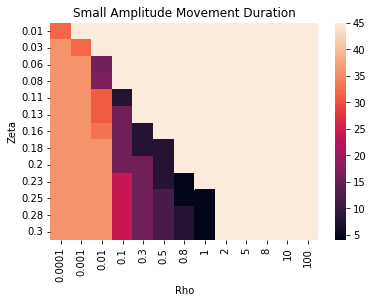

In [ ]:
# iii) Duration of policy switch

switch_durations = np.zeros((len(ZETA), len(OMEGA), len(RHO), N))
for ze in range(len(ZETA)):
  for om in range(len(OMEGA)):
    for rh in range(len(RHO)):
      for n in range(N):
        v = pol_switch[ze, om, rh, :, n]
        pol_switch_times = np.where(v == 1)[0] # select timepoints where policy 1 > policy 0
        if len(pol_switch_times) >= 2: # if two switches occured take the difference
          switch_durations[ze, om, rh, n] = pol_switch_times[-1] - pol_switch_times[0]
        else:
          switch_durations[ze, om, rh, n] = 45 # max difference when no second switch occured
           

mean_switch_durations = switch_durations.mean(axis=-1)
fig = sb.heatmap(mean_switch_durations.squeeze(), xticklabels=RHO, yticklabels=ZETA)
fig.set(title='Small Amplitude Movement Duration')
fig.set(xlabel='Rho', ylabel='Zeta')

[Text(33.0, 0.5, 'Zeta'), Text(0.5, 15.0, 'Rho')]

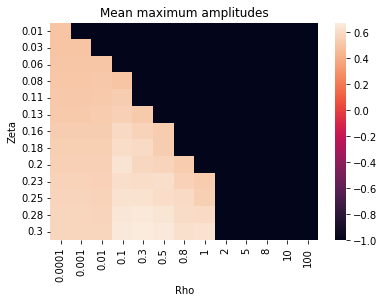

In [ ]:
# iv) avg height of small movement behaviour (NOT USED)

heights = np.zeros((len(ZETA), len(OMEGA), len(RHO), N))

small_movement_values = pol_post[:, :, :, :, 1, :]

for ze in range(len(ZETA)):
  for om in range(len(OMEGA)):
    for rh in range(len(RHO)):
      for n in range(N):
        # select means of values where the policy 1 is > 0.5
        v = small_movement_values[ze, om, rh, :, n]
        indices = np.where(v > 0.5)[0]
        above_05 = v[indices]
        heights[ze, om, rh, n] = above_05.mean() if len(above_05) else -1

heights_mean = heights.mean(axis=-1)
fig = sb.heatmap(heights_mean.squeeze(), xticklabels=RHO, yticklabels=ZETA)
fig.set(title='Mean maximum amplitudes')
fig.set(xlabel='Rho', ylabel='Zeta')